In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read data

In [2]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")

In [ ]:
#resample to month ends
mhm_fluxes_mon= mhm_fluxes.resample(time='ME').mean()



In [ ]:
#select values for June
data=mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month==6)

#select a time series from a specific location
sample_ts = mhm_fluxes_mon['SM_Lall'].sel(lon=5.5, lat=51.5, method='nearest')
sample_ts1 = data['SM_Lall'].sel(lon=slice(5.5,5.7), lat=slice(51.5,51.7)).mean(dim=['lat','lon'])

In [ ]:
ts_df = sample_ts.to_dataframe().drop(columns=['lat', 'lon'])


<Axes: xlabel='time'>

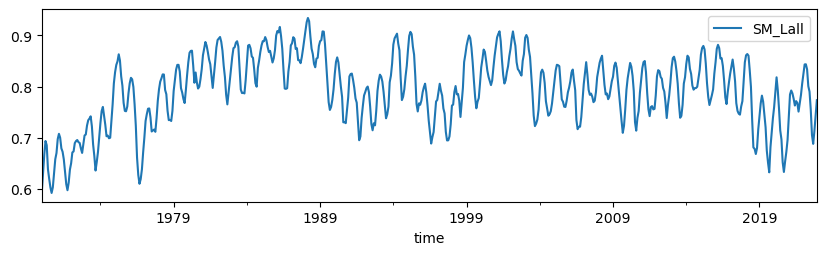

In [ ]:
ts_df.plot(figsize=(10,2.5))

In [ ]:
#ts_df.to_numpy()
#extract values
soil_moisture = ts_df.values[:,0]

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# Define a range of bandwidths to test
bandwidths =np.linspace(0.001, 10, 20)

# Perform cross-validated grid search for bandwidth
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(soil_moisture[:, None])

# Optimal bandwidth
optimal_h = grid.best_params_['bandwidth']
print(f"Optimal bandwidth: {optimal_h}")

Optimal bandwidth: 0.5272631578947369


Text(0.5, 0, 'Soil Moisture (%)')

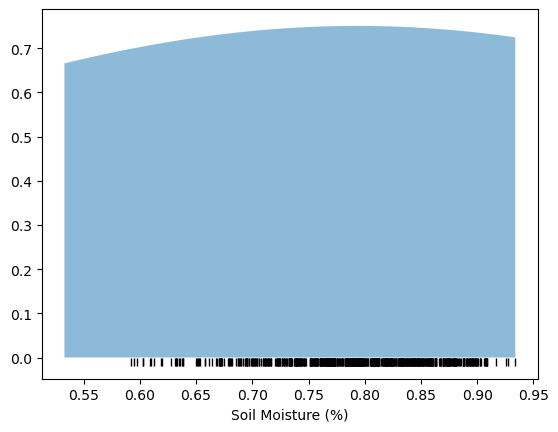

In [ ]:
# kernel density estimation
kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
kde.fit(soil_moisture[:, None])

#plot the kde
x = np.linspace(soil_moisture.min()*0.9, soil_moisture.max(), 1000)
logprob = kde.score_samples(x[:, None])
plt.fill_between(x, np.exp(logprob), alpha=0.5)
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|k', markeredgewidth=1)
plt.xlabel('sm')

#### Bandwidth selection
https://towardsdatascience.com/bounded-kernel-density-estimation-2082dff3f47f

Silverman's rule of thumb, optimal when the underlying density being estimated is Gaussian

$h = \sigma * (\frac{4}{3n})^{0.2}$

In [ ]:
n=len(soil_moisture)
stdev = np.std(soil_moisture)

In [ ]:
h = 1.0587*stdev*n**-0.2
h

0.014350230020807509

In [ ]:
import numpy as np

def feddes_et_reduction(soil_moist, soil_moist_FC, wilting_point, frac_roots):
    """
    Stress factor for reducing evapotranspiration based on actual soil moisture using Feddes equation.
    
    Parameters:
    soil_moist (float): Soil moisture of each horizon [mm]
    soil_moist_FC (float): Soil moisture below which actual ET is reduced [mm]
    wilting_point (float): Permanent wilting point
    frac_roots (float): Fraction of Roots in soil horizon is reduced [mm]
    
    Returns:
    float: ET reduction factor
    """
    if soil_moist >= soil_moist_FC:
        return frac_roots
    elif soil_moist > wilting_point:
        return frac_roots * (soil_moist - wilting_point) / (soil_moist_FC - wilting_point)
    else:
        return 0.0

def jarvis_et_reduction(soil_moist, soil_moist_sat, wilting_point, frac_roots, jarvis_thresh_c1):
    """
    Stress factor for reducing evapotranspiration based on actual soil moisture using Jarvis equation.
    
    Parameters:
    soil_moist (float): Soil moisture of each horizon [mm]
    soil_moist_sat (float): Saturated Soil moisture content [mm]
    wilting_point (float): Permanent wilting point
    frac_roots (float): Fraction of Roots in soil horizon is reduced [mm]
    jarvis_thresh_c1 (float): Parameter C1 from Jarvis formulation
    
    Returns:
    float: ET reduction factor
    """
    theta_inorm = (soil_moist - wilting_point) / (soil_moist_sat - wilting_point)
    theta_inorm = np.clip(theta_inorm, 0.0, 1.0)
    
    if theta_inorm >= jarvis_thresh_c1:
        return frac_roots
    else:
        return frac_roots * (theta_inorm / jarvis_thresh_c1)

def soil_moisture(processCase, frac_sealed, water_thresh_sealed, pet, evap_coeff, soil_moist_sat, frac_roots, 
                  soil_moist_FC, wilting_point, soil_moist_exponen, jarvis_thresh_c1, aet_canopy, prec_effec, 
                  runoff_sealed, storage_sealed, infiltration, soil_moist, aet, aet_sealed):
    """
    Soil moisture in different soil horizons.
    
    Parameters:
    processCase (int): 1 - Feddes equation for PET reduction, 2 - Jarvis equation for PET reduction
    frac_sealed (float): Fraction of sealed area
    water_thresh_sealed (float): Threshold water depth in impervious areas [mm TS-1]
    pet (float): Reference evapotranspiration [mm TS-1]
    evap_coeff (float): Evaporation coefficient for free-water surface of that current month
    soil_moist_sat (np.ndarray): Saturation soil moisture for each horizon [mm]
    frac_roots (np.ndarray): Fraction of Roots in soil horizon
    soil_moist_FC (np.ndarray): Soil moisture below which actual ET is reduced [mm]
    wilting_point (np.ndarray): Permanent wilting point for each horizon [mm]
    soil_moist_exponen (np.ndarray): Exponential parameter to how non-linear is the soil water retention
    jarvis_thresh_c1 (float): Jarvis critical value for normalized soil water content
    aet_canopy (float): Actual ET from canopy [mm TS-1]
    prec_effec (float): Effective precipitation (rain + snow melt) [mm]
    runoff_sealed (float): Direct runoff from impervious areas
    storage_sealed (float): Retention storage of impervious areas
    infiltration (np.ndarray): Recharge, infiltration intensity or effective precipitation of each horizon [mm TS-1]
    soil_moist (np.ndarray): Soil moisture of each horizon [mm]
    aet (np.ndarray): Actual ET [mm TS-1]
    aet_sealed (float): Actual ET from free-water surfaces, i.e impervious cover [mm TS-1]
    """
    eps_dp = np.finfo(float).eps

    # Impervious cover process
    runoff_sealed = 0.0
    aet_sealed = 0.0

    if frac_sealed > 0.0:
        tmp = storage_sealed + prec_effec

        if tmp > water_thresh_sealed:
            runoff_sealed = tmp - water_thresh_sealed
            storage_sealed = water_thresh_sealed
        else:
            runoff_sealed = 0.0
            storage_sealed = tmp

        if water_thresh_sealed > eps_dp:
            aet_sealed = (pet / evap_coeff - aet_canopy) * (storage_sealed / water_thresh_sealed)
            if aet_sealed < 0.0:
                aet_sealed = 0.0
        else:
            aet_sealed = np.inf

        if storage_sealed > aet_sealed:
            storage_sealed -= aet_sealed
        else:
            aet_sealed = storage_sealed
            storage_sealed = 0.0

    # N-layer soil module
    aet.fill(0.0)
    infiltration.fill(0.0)
    prec_effec_soil = prec_effec

    for hh in range(len(soil_moist_sat)):
        if hh != 0:
            prec_effec_soil = infiltration[hh - 1]

        if soil_moist[hh] > soil_moist_sat[hh]:
            infiltration[hh] = prec_effec_soil
        else:
            if soil_moist[hh] > eps_dp:
                frac_runoff = np.exp(soil_moist_exponen[hh] * np.log(soil_moist[hh] / soil_moist_sat[hh]))
            else:
                frac_runoff = 0.0
            tmp = prec_effec_soil * (1.0 - frac_runoff)

            if (soil_moist[hh] + tmp) > soil_moist_sat[hh]:
                infiltration[hh] = prec_effec_soil + (soil_moist[hh] - soil_moist_sat[hh])
                soil_moist[hh] = soil_moist_sat[hh]
            else:
                infiltration[hh] = prec_effec_soil - tmp
                soil_moist[hh] += tmp

        aet[hh] = pet - aet_canopy if hh == 0 else pet - aet_canopy - np.sum(aet[:hh][aet[:hh] > 0.0])

        if processCase in [1, 4]:
            soil_stress_factor = feddes_et_reduction(soil_moist[hh], soil_moist_FC[hh], wilting_point[hh], frac_roots[hh])
        elif processCase in [2, 3]:
            soil_stress_factor = jarvis_et_reduction(soil_moist[hh], soil_moist_sat[hh], wilting_point[hh], frac_roots[hh], jarvis_thresh_c1)

        aet[hh] *= soil_stress_factor

        if aet[hh] < 0.0:
            aet[hh] = 0.0

        if soil_moist[hh] > aet[hh]:
            soil_moist[hh] -= aet[hh]
        else:
            aet[hh] = soil_moist[hh] - eps_dp
            soil_moist[hh] = eps_dp

        if soil_moist[hh] < eps_dp:
            soil_moist[hh] = eps_dp